<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cross-validation</a></span></li><li><span><a href="#Train-model-over-full-train-set" data-toc-modified-id="Train-model-over-full-train-set-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train model over full train set</a></span></li></ul></li><li><span><a href="#Predict-over-test-set" data-toc-modified-id="Predict-over-test-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict over test set</a></span></li><li><span><a href="#Submit-predictions" data-toc-modified-id="Submit-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Submit predictions</a></span></li></ul></div>

----

**<big>ESA Datalabs Ariel Hackathon</big>**

Modelling starter code

----

----

# Imports

In [1]:
import gc, requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

import sys
sys.path.append('esac-hackathon-starter-code-dev')
from adc21 import *

---

**Load dataset**

In [2]:
# Please adjust the below path with your team's workspace, e.g. '/media/team_workspaces/MYTEAMNAME/'
DATA_PATH = '/media/team_workspaces/CoRoT-7-b/'

In [3]:
%%time
DATA = load_dataset(DATA_PATH + 'ADC21esac_train.pkl')
#DATA = load_dataset(DATA_PATH + 'ADC21esac_test.pkl')
print(type(DATA))

<class 'adc21.data.dataset'>
CPU times: user 1.24 s, sys: 3 s, total: 4.24 s
Wall time: 4.25 s


----

----

# Data preparation

You are free to train your ML models over the raw data, or over data pre-processed in any way you choose.

We offer below a possible way to prepare the data for modelling.

This data preparation pipeline is also in use at the **https://ariel-lightcurve-challenge.mlanalytics.ai/** website. You are encouraged to use the website to explore the dataset, and the impact of different transformations.

***Parameters of the data pre-processing pipeline***:

**WINDOW_RADIUS**
* Improve estimate of observation at time t by taking the mean over all values observed in the [t-r, t+r] time window, where r is the chosen radius. Process is applied for all time instants, of all wavelength channels.

**AGGR_NUM_OBS**
* We have the chance to observe the exoplanet for up to 10 of its \"years\", 10 different transits in front of its star (in this dataset). We know enough about the planet's orbit to know the point of a transit that should match the equivalent point of a different transit. When taking the mean to estimate the light curve value at time t, it is then best to consider also the matching observations of up to how many different transits?

**MIRROR_STACKING**
* An ideal observation of a planet's transit, with no imprecision in the measurements, would produce a smooth light curve, symmetrical around the point of maximum dip. What we know of the planet's orbit allows us to estimate when is that point reached. In this dataset, it's at the t=150 instant. When estimating the true value at t=100, for instance, the measurements at t=200 are then also informative. Choosing this option, the time-symmetrical measurements are then also included when calculating the mean. By doing so, observe how the light curves become symmetrical. For training the AI model, it is then enough to consider just half the curve, as it would be redundant to see same values again on the other side of t=150.

**MEAN_TYPE**
* The settings above define the set of values we'll consider as relevant to the estimation of the true value at a given time instant. What is then the best way to aggregate all those separate measurements? We'll be using what's known as a "[generalized mean](https://en.wikipedia.org/wiki/Generalized_mean)" for that. This equation has a single parameter, p. For p=1 it becomes the well known arithmetic mean. Different settings will favour either the smaller (p<0) or larger values under aggregation (p>0). The plots may show imperceptible differences, but the AI model will be sensitive to it!

**GRID_PTS_NUM**
* How many different things should the AI model consider at once? You want to make the learning problem as simple as possible, but not so simple that the AI is not exposed to important information, and is then unable to perform well. The AI won't be seeing the full light curve – it contains 300×55=16,500 measurements for just one transit! Instead, we perform aggregations at just a few carefully chosen time steps, and have the AI learn over just those. This parameter then controls the number of different variables you give to the AI model, and so the complexity of the learning problem.

**GRID_PTS_SPACING**
* Is it better to focus around the t=150 instant, or does the AI need to consider also the slope down from 1.0 relative brightness? This parameter controls the spacing, in minutes, between the grid points chosen in the previous setting. It determines the kind of information the AI will consider when learning how to extract the spectrum from the light curve.

In [4]:
# configure the desired data pre-processing pipeline

data_setup = dict(
    WINDOW_RADIUS    = 14,
    AGGR_NUM_OBS     = 10,
    MIRROR_STACKING  = True,
    MEAN_TYPE_P      = -2,
    
    GRID_PTS_NUM     = 8,
    GRID_PTS_SPACING = 6,
    )


setup_summary(data_setup)
data_setup

With these settings, a star has its observations transformed into a 501-dimensional representation: 8+1 grid points × 55 wavelength channels + 6 stellar/planet parameters.
Each grid point aggregates with a p=-2 a total of 580 values: a time window 2×14+1 minutes wide × 10 planetary transits × 2 time symmetrical observations.


{'WINDOW_RADIUS': 14,
 'AGGR_NUM_OBS': 10,
 'MIRROR_STACKING': True,
 'MEAN_TYPE_P': -2,
 'GRID_PTS_NUM': 8,
 'GRID_PTS_SPACING': 6}

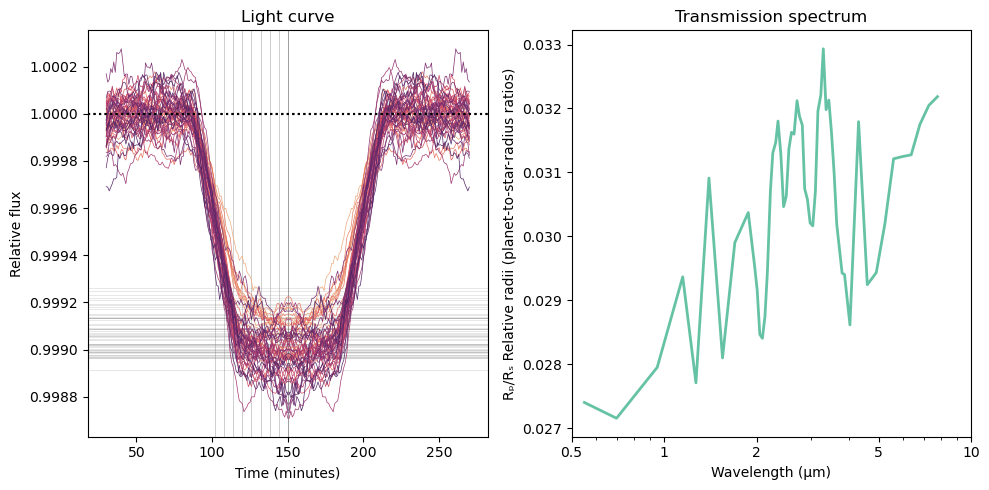

In [5]:
# Visualization of how the data pre-processing defined above transforms a given planet's observations
visualize_setup(DATA, data_setup, planet_id=1759)

\
To transform the whole dataset using the `data_setup` defined above, first call `configure_pipeline()`, and then `prepare_data()`.

In [6]:
X_pipeline = configure_pipeline(**data_setup)
#X_pipeline

In [7]:
%%time
data = prepare_data(DATA, X_pipeline)

functools.partial(<function X__set_to__obs_encodings at 0x7f4a3485cc20>, agg_stellar=False, agg_photon=10, agg=-2, window_radius=14, grid=(102, 108, 114, 120, 126, 132, 138, 144, 150), mirror_stacking=True)


functools.partial(<function X__stack_with__par at 0x7f4a3485f060>, par_var='X_par')
CPU times: user 6.68 s, sys: 950 ms, total: 7.63 s
Wall time: 7.71 s


In [8]:
type(data), data.X.dtype, data.y.dtype
print(data.X)

[[3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 5.3037550e-02
  5.2174170e-02 5.2403864e-02]
 [3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 5.7268023e-02
  5.7382915e-02 5.9075475e-02]
 [3.6674199e+03 5.0000000e+00 4.3950000e-01 ... 6.1646838e-02
  6.0910515e-02 6.0364481e-02]
 ...
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 4.5370106e-02
  3.4155264e-02 0.0000000e+00]
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 6.8093352e-02
  5.5162277e-02 4.5016646e-02]
 [4.7310000e+03 4.5000000e+00 6.9000000e-01 ... 6.5951869e-02
  6.6743776e-02 6.6577017e-02]]


In [9]:
data.y

array([[0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       [0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       [0.05427011, 0.05390767, 0.05448135, ..., 0.05766987, 0.05825472,
        0.05851034],
       ...,
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ],
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ],
       [0.03866225, 0.03808885, 0.03876797, ..., 0.0436143 , 0.04515038,
        0.0455361 ]], dtype=float32)

In [10]:
data.X.shape

(10000, 501)

In [11]:
data.y.shape

(10000, 55)

\
**At this point you have a defined ML problem: given `data.X`, predict `data.y`.**

\
If you don't need the raw data anymore, you can remove it from memory.

In [12]:
del DATA
del data.X_obs

gc.collect()

17093

In [13]:
# Standardizing data
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(data.X)
(X_st, x, X_st_params) = standardizer(data.X)

X_st.mean(), X_st.std()
y_true = data.y

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_st, dtype=torch.float32)
y_tensor = torch.tensor(y_true, dtype=torch.float32)

----

# Modelling

Let's start simple, with a linear model ([sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).

In [14]:
# Define the Neural Network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_size)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Model hyperparameters
input_size = X_st.shape[1]  # 900 * 55
hidden1 = 1024
hidden2 = 256
output_size = 55
learning_rate = 0.0005

## Training Neural Network

In [15]:
# Initialize model
model = NeuralNet(input_size, hidden1, hidden2, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [33]:
# Create DataLoader for batch training
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.000006
Epoch [20/100], Loss: 0.000003
Epoch [30/100], Loss: 0.000003
Epoch [40/100], Loss: 0.000145
Epoch [50/100], Loss: 0.000002
Epoch [60/100], Loss: 0.000003
Epoch [70/100], Loss: 0.000002
Epoch [80/100], Loss: 0.000004
Epoch [90/100], Loss: 0.000005
Epoch [100/100], Loss: 0.000004


-----

-----

# Predict over test set

In [34]:
%%time
TEST_DATA = load_dataset(DATA_PATH + 'ADC21esac_test.pkl')

CPU times: user 552 ms, sys: 327 ms, total: 879 ms
Wall time: 881 ms


In [35]:
data_setup

{'WINDOW_RADIUS': 14,
 'AGGR_NUM_OBS': 10,
 'MIRROR_STACKING': True,
 'MEAN_TYPE_P': -2,
 'GRID_PTS_NUM': 8,
 'GRID_PTS_SPACING': 6}

\
Encode the test set using the same data pre-processing pipeline thas was used over the train set.

In [36]:
%%time
#X_pipeline = configure_pipeline(**data_setup)
test_data = prepare_data(TEST_DATA, X_pipeline)
test_data.X.shape

functools.partial(<function X__set_to__obs_encodings at 0x7f4a3485cc20>, agg_stellar=False, agg_photon=10, agg=-2, window_radius=14, grid=(102, 108, 114, 120, 126, 132, 138, 144, 150), mirror_stacking=True)


functools.partial(<function X__stack_with__par at 0x7f4a3485f060>, par_var='X_par')
CPU times: user 3.46 s, sys: 7.97 ms, total: 3.47 s
Wall time: 3.48 s


(5120, 501)

In [37]:
del TEST_DATA
del test_data.X_obs

gc.collect()

0

In [38]:
test_X_st = standardizer(test_data.X, avg_std=X_st_params)[0]
test_X_tensor = torch.tensor(test_X_st, dtype=torch.float32)

# Make predictions
with torch.no_grad():  # Disable gradient computation for inference
    test_y_pred = model(test_X_tensor)

#test_y_pred = model(test_X_tensor).detach().numpy()

print(type(test_y_pred))

test_y_pred_np = test_y_pred.numpy()
test_y_pred = test_y_pred_np

<class 'torch.Tensor'>


-----

-----

# Submit predictions

The data pre-processing pipeline may aggregate observations at different levels:
* aggregations across photon noise instances leave us with 1 sample per planet / stellar_spot combination (10 samples per planet).
* aggregations across stellar spot instances, and their photon noise instances leave us with 1 sample per planet.

Below, in `ix_all` are the indices of all samples in the test set. Submissions must provide one prediction for each of those samples. Encoding left us with the `ix_enc` indices. If they differ, we must then propagate predictions to the other samples of the same planet / stellar_spot.

In [39]:
ix_all = test_data.X_par_all[OBSERV_INDEX].set_index(OBSERV_INDEX, append=True).index
ix_enc = test_data.X_par[    OBSERV_INDEX].set_index(OBSERV_INDEX, append=True).index

In [41]:
# Indexed DataFrame version of the predictions matrix

test_y_pred_df = pd.DataFrame(
    test_y_pred,
    #index=test_data.X_par.index,
    index=ix_enc,
    columns=[f'w{i+1}' for i in range(55)]
)

test_y_pred_df

print(type(test_y_pred))

<class 'numpy.ndarray'>


Propagate predictions across samples of the same planet / stellar_spot.

In [42]:
test_y_pred_df = test_y_pred_df.reindex(ix_all).fillna(method='ffill')
test_y_pred_df

,,,,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w46,w47,w48,w49,w50,w51,w52,w53,w54,w55
,planet,stellar_spot,photon,,,,,,,,,,,,,,,,,,,,,
0003_01_01.txt,3,1,1,0.037076,0.036834,0.037648,0.038797,0.037928,0.040344,0.038850,0.039109,0.040130,0.039988,...,0.041926,0.041994,0.040807,0.040848,0.041472,0.041242,0.041172,0.042116,0.042267,0.042400
0003_01_02.txt,3,1,2,0.037076,0.036834,0.037648,0.038797,0.037928,0.040344,0.038850,0.039109,0.040130,0.039988,...,0.041926,0.041994,0.040807,0.040848,0.041472,0.041242,0.041172,0.042116,0.042267,0.042400
0003_01_03.txt,3,1,3,0.037076,0.036834,0.037648,0.038797,0.037928,0.040344,0.038850,0.039109,0.040130,0.039988,...,0.041926,0.041994,0.040807,0.040848,0.041472,0.041242,0.041172,0.042116,0.042267,0.042400
0003_01_04.txt,3,1,4,0.037076,0.036834,0.037648,0.038797,0.037928,0.040344,0.038850,0.039109,0.040130,0.039988,...,0.041926,0.041994,0.040807,0.040848,0.041472,0.041242,0.041172,0.042116,0.042267,0.042400
0003_01_05.txt,3,1,5,0.037076,0.036834,0.037648,0.038797,0.037928,0.040344,0.038850,0.039109,0.040130,0.039988,...,0.041926,0.041994,0.040807,0.040848,0.041472,0.041242,0.041172,0.042116,0.042267,0.042400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381_10_06.txt,4381,10,6,0.139838,0.139424,0.139726,0.140783,0.140178,0.141784,0.142381,0.142276,0.142675,0.142659,...,0.138535,0.138673,0.140291,0.143743,0.142053,0.143236,0.141387,0.143985,0.144203,0.146115
4381_10_07.txt,4381,10,7,0.139838,0.139424,0.139726,0.140783,0.140178,0.141784,0.142381,0.142276,0.142675,0.142659,...,0.138535,0.138673,0.140291,0.143743,0.142053,0.143236,0.141387,0.143985,0.144203,0.146115
4381_10_08.txt,4381,10,8,0.139838,0.139424,0.139726,0.140783,0.140178,0.141784,0.142381,0.142276,0.142675,0.142659,...,0.138535,0.138673,0.140291,0.143743,0.142053,0.143236,0.141387,0.143985,0.144203,0.146115


\
**Submit**

In [43]:
s_path = 'submissions/'
os.makedirs(s_path, exist_ok=True)

s_file = str(pd.Timestamp('now').round('s')).replace(':', '.') + '.csv'
s_file

'2025-01-17 15.38.30.csv'

Write predictions to the hard drive.

In [44]:
submission = test_y_pred_df.reset_index(level=OBSERV_INDEX, drop=True).rename_axis(index='files')

In [45]:
submission.to_csv(s_path + s_file)

# Ensure index is reset (if needed)
#test_y_pred_df.reset_index(drop=True, inplace=True)

# Save to CSV
#submission_file = "submission.csv"
#test_y_pred_df.to_csv(submission_file, index=False, float_format="%.6f")

#print(f"Submission file saved: {submission_file}")

Submit predictions using the REST API.

In [46]:
# Enter your team's identifiers
team_id = {
    "team_no": "3",
    "team_name": "CoRoT-7-b",
    "secret_key": "2006",
    }

In [47]:
files = {"file": (s_file, submission.to_csv(), "text/csv")}

response = requests.post(
    "https://www.ariel-datachallenge.space/api/score/calculate/",
    data=team_id, files=files)

print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    response_json = response.json()
    print(f"Successful submission by '{team_id['team_name']}', " +
          f"with a public leaderboard score of {response_json['score']}")
else:
    print(f"Submission failure:", response.json())

Status Code: 200
Successful submission by 'CoRoT-7-b', with a public leaderboard score of 9094.192215432235


These are the error codes you may come across when submitting:

    Wrong file type : File is not in .csv format
    File processing failed : The .csv file is not formatted correctly
    Invalid secret code : Typo in secret code or wrong code
    Invalid data format : The file has non-numeric values
    Wrong data format : The num of rows or column is not as expected
    Invalid Submission : Empty file submitted

-----

-----